In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import correlate
import os
import pandas as pd
import tensorflow as tf
import heapq
import time 
arr = np.load("./PEMS04/pems04.npz")
# only contains "data" key.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
arr_pems8 = np.load("./PEMS08/pems08.npz")
pems8_data = arr_pems8["data"]

pems08_data = np.load("../ASTGCN-r-pytorch-master/data/PEMS08/PEMS08_r1_d0_w0_astcgn.npz")


In [3]:
def pplot(vec):
    plt.plot(list(range(len(vec))), vec)

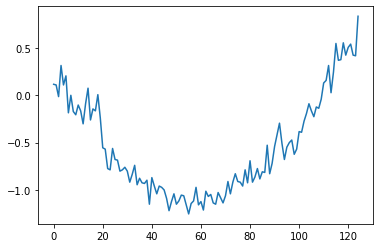

In [4]:
pplot(pems08_data["test_x"][400:525,0,0,11],)

In [5]:
pems04_data = np.load("../ASTGCN-r-pytorch-master/data/PEMS04/PEMS04_r1_d0_w0_astcgn.npz")

In [6]:
# 307 detectors. 
print(len(pems04_data["test_x"][:,0,0,0]))
print(pems04_data["test_target"][:,0,0])
pems04_data["test_x"][:,0,0,0]



3394
[ 54.  35.  48. ... 112. 123. 118.]


array([-1.21568372, -1.10704201, -1.00479099, ..., -0.26347109,
       -0.1995642 , -0.10370387])

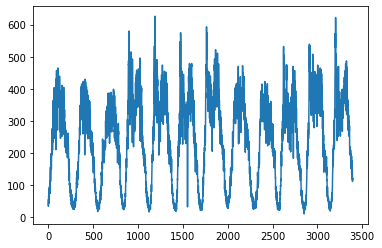

In [7]:

def plt_attr(col_name):
    plt.plot(list(range(len(pems04_data[col_name][:,0,0]))), pems04_data[col_name][:,0,0])
    
# 
plt_attr("test_target")

In [8]:
def swap(x,y):
    temp = x
    x = y
    y = temp
    return x,y

In [9]:
# 3684 possible sequences of 3394 observations to perturb.
# we may need to use joblib to pseudo-parallelize 
307*12

3684

In [10]:
# per detector, shifted by at most 12 positions.
pems04_data["test_x"][3390:3393, 0, 0:1, 11]

array([[-0.32737798],
       [-0.47436382],
       [-0.60856829]])

In [11]:
first_portion = pems04_data["test_x"][0:12, :, 0:1, :]


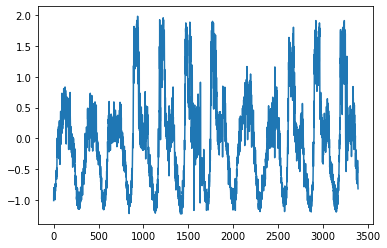

In [12]:
plt.plot(pems04_data["test_x"][:, 1, 0:1, 0])
        
        
        


In [13]:
'''
:brief: sample_similar_segments - prints the .
:param:
:param: ref_portion - 
:param: kwargs - key word arguments
:return: 
'''
def sample_similar_segments(data_vec, jth, ref_portion, **kwargs):
    if ("sample_type" in kwargs):
        if (kwargs["sample_type"] == "mc_sample_strumbelj"):
            mc_sample_strumbelj(data_vec, jth, most_similar_segments(ref_portion[0],ref_portion[1],
                                                                data_vec, 10))
    else:
        print("No specified sample type.")
        return []

def perturb_data_file(data_file_name, jth, ref_portion, data_type, **kwargs):
    if (data_type == np.ndarray):
        assert "data_entry" in kwargs, \
            "Data entry in np.ndarray has no data entry key."
        assert type(data_entry_dict["data_entry"]) == int,\
            "np.ndarray data entry not an integer."
        assert data_file_name.endswith(".npz") or data_file_name.endswith(".npy"),\
                "Specified data file not valid given data type."
        data_vec = np.load(data_file_name)[data_entry_dict["data_entry"]]
        sample_similar_segments(data_vec, jth, ref_portion, kwargs)
    elif (data_type == pd.core.frame.DataFrame):
        assert data_file_name.endswith(".csv"), "File not valid csv."
        assert "feature_perturb" in kwargs,\
            "Feature to perturb in dataframe not a key."
        assert type(data_entry_dict["feature_perturb"]) == str,\
            "pd.DataFrame feature name is not a string."
        df = pd.read_csv(data_file_name)
        data_vec = df[kwargs["feature_perturb"]]
        sample_similar_segments(data_vec, jth, ref_portion, kwargs)
    else:
        raise Exception(f"Data Type Not Yet Supported: {type(data_type)}")

40


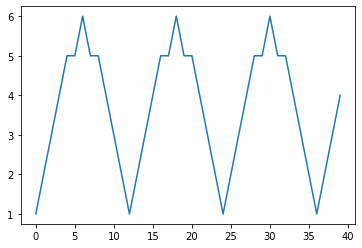

In [14]:
v = [1,2,3,4,5,5,6,5,5,4,3,2,1,2,3,4,5,5,6,5,5,4,3,2,1,2,3,4,5,5,6,5,5,4,3,2,1,2,3,4]
print(len(v))
plt.plot(v)
# mc_sample_strumbelj(v, [[0,7],[13,18],[26,30]])

In [15]:
def average(L):
    if len(L) == 0:
        return 0
    return sum(L)/len(L)
def add_on_reciprocal(diff):
    if diff == 0:
        add_on = float('inf')
    else:
        add_on = 1/diff
    return add_on



# Noise Reduction Techniques
def linear_smoother(ts, num_neighbors, weight_method="gaussian"):
    averaged_points = []
    # every 20 points
    points_to_include = []
    for i in range(len(ts)):
        closest = []
        heapq.heapify(closest)
        downward, upward = i, i
        if weight_method == "gaussian":
            under_neighbors = i-num_neighbors
            above_neighbors = i+num_neighbors
            while under_neighbors <= downward and under_neighbors >= 0 and\
                  i+num_neighbors >= upward and above_neighbors < len(ts):
                # sorts by the first element of tuple
                if len(closest) >= num_neighbors:
                    heapq.heappop(closest)
                else:
                    heapq.heappush(closest,(add_on_reciprocal(i-downward),ts[downward]))
                if (len(closest) >= num_neighbors):
                    heapq.heappop(closest)
                else:
                    heapq.heappush(closest,(add_on_reciprocal(upward-i), ts[upward]))  
                
                downward -= 1
                upward += 1
            while under_neighbors <= downward and under_neighbors >= 0:
                if len(closest) >= num_neighbors:
                    heapq.heappop(closest)
                else:
                    heapq.heappush(closest,(add_on_reciprocal(i-downward),ts[downward]))
                downward -= 1           
            while i+num_neighbors >= upward and above_neighbors < len(ts):
                if len(closest) >= num_neighbors:
                    heapq.heappop(closest)
                else:
                    heapq.heappush(closest,(add_on_reciprocal(upward-i), ts[upward]))   
                upward += 1
            heap_items = list(map(lambda x: x[1], [heapq.heappop(closest) \
                                                       for i in range(len(closest))]))
            avg = average(heap_items)
            averaged_points.append(avg)
            # we collect twice as many points as total/num_neighbors
            if (i%(num_neighbors//2) == 0):
                points_to_include.append(avg)
        else:
            # rather than a weighted average of nearest data points, 
            # we take ordinary average.
            pass
    return averaged_points, points_to_include


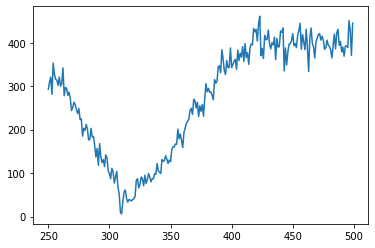

In [16]:
plt.plot(range(250,500),pems8_data[250:500,0,0])

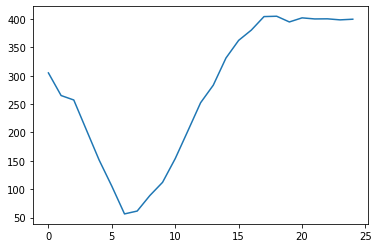

In [17]:
averaged_points, points_to_include = linear_smoother(pems8_data[250:500,0,0],20, "gaussian")
plt.plot(range(len(points_to_include)),points_to_include)

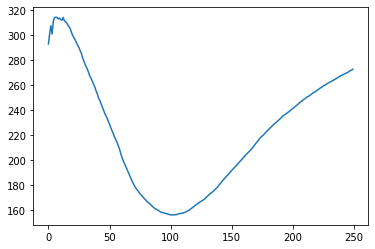

In [18]:
data = pd.Series(pems8_data[250:500,0,0])
windows = data.expanding()
moving_averages = windows.mean()
plt.plot(moving_averages)

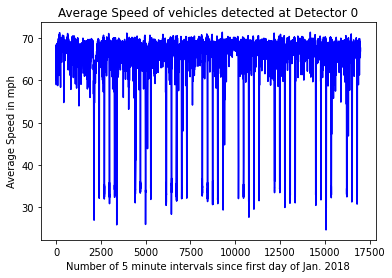

In [19]:
# Third entry in the 3D array contains average speed - every 5 minutes between observations.
# In major metropolitan areas of California.
# 307 detectors
detector = 0
avg_speed_pems4 = plt.plot(list(range(len(arr['data'][:,0]))),arr['data'][:,detector,2], color="blue")
pems4_speed_title = plt.title("Average Speed of vehicles detected at Detector {}".format(detector))
pems4_speed_x = plt.xlabel("Number of 5 minute intervals since first day of Jan. 2018")
pems4_speed_y = plt.ylabel("Average Speed in mph")

(array([1.4777e+04, 1.6500e+03, 3.7800e+02, 1.2200e+02, 4.4000e+01,
        5.0000e+00, 8.0000e+00, 2.0000e+00, 2.0000e+00, 4.0000e+00]),
 array([5.33425414e+10, 1.02006068e+30, 2.04012136e+30, 3.06018204e+30,
        4.08024273e+30, 5.10030341e+30, 6.12036409e+30, 7.14042477e+30,
        8.16048545e+30, 9.18054613e+30, 1.02006068e+31]),
 <BarContainer object of 10 artists>)

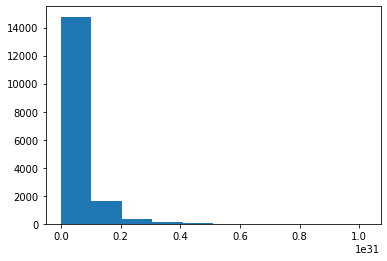

In [20]:
plt.hist(np.exp(arr['data'][:,detector,2]))

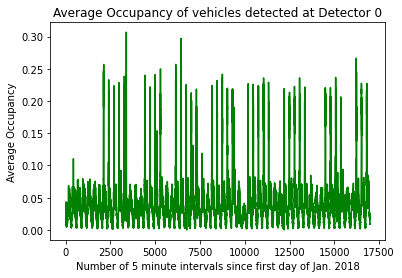

In [21]:
# Second entry - occupancy - fraction of time a vehicle is over a detector.
detector = 0
pems4_occupancy_title = plt.title("Average Occupancy of vehicles detected at Detector {}".format(detector))
pems4_occupancy_x = plt.xlabel("Number of 5 minute intervals since first day of Jan. 2018")
pems4_occupancy_y = plt.ylabel("Average Occupancy")
pems4_occupancy = plt.plot(list(range(len(arr['data'][:,0]))),arr['data'][:,detector,1], color="green")

(array([7.353e+03, 7.872e+03, 8.710e+02, 7.800e+01, 1.340e+02, 2.820e+02,
        2.900e+02, 9.100e+01, 1.800e+01, 3.000e+00]),
 array([0.     , 0.03067, 0.06134, 0.09201, 0.12268, 0.15335, 0.18402,
        0.21469, 0.24536, 0.27603, 0.3067 ]),
 <BarContainer object of 10 artists>)

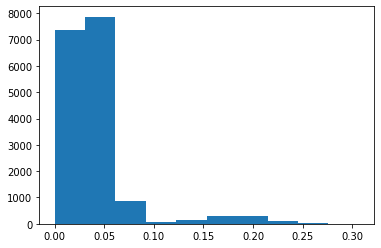

In [22]:
plt.hist(arr['data'][:,detector,1])

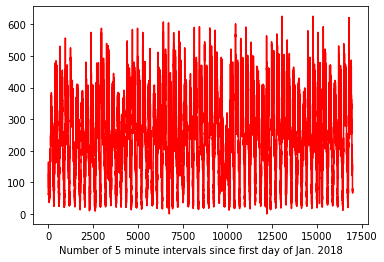

In [23]:
# First entry - flow - number of vehicles passing over the detector in 30 second period.

pems4_flow = plt.plot(list(range(len(arr['data'][:,0]))),arr['data'][:,0,0],color="red")
pems4_flow_x = plt.xlabel("Number of 5 minute intervals since first day of Jan. 2018")
pems4_flow_y = plt.ylabel("")

-1.7761501100187818e-12


(array([2.000e+00, 0.000e+00, 0.000e+00, 2.600e+01, 1.225e+03, 2.013e+03,
        1.626e+03, 3.384e+03, 7.002e+03, 1.714e+03]),
 array([0.        , 0.50019988, 1.00039976, 1.50059964, 2.00079952,
        2.5009994 , 3.00119928, 3.50139916, 4.00159904, 4.50179892,
        5.0019988 ]),
 <BarContainer object of 10 artists>)

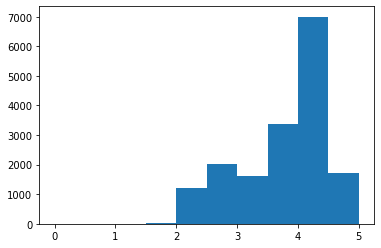

In [21]:
print(average((arr['data'][:,0,0])**(1/3)-5.94739396423))
plt.hist((arr['data'][:,0,0])**(1/4))

In [22]:
# we want the distributions of the features to be nearly 
# normal. We're using ks test to ascertain this ~N(0,1).
from scipy import stats
stats.kstest((arr['data'][:,0,0])**(1/3)-5.94739396423, 'norm')

KstestResult(statistic=0.18832315012206158, pvalue=0.0)

In [23]:
A414df = pd.read_csv("A414.csv")

In [28]:
def rows_to_keep_no_dups(df, var):
    rows_keep = []
    prev = None
    for i in range(len(df)):
        if not prev or (df.iloc[i][var] != prev):
            # either the first row or distinct value.
            rows_keep.append(i)
        prev = df.iloc[i][var]
    return rows_keep
    

In [32]:
start = time.time()
no_dups = A414df.iloc[rows_to_keep_no_dups(A414df, "AverageJT")]
no_dups = no_dups.iloc[rows_to_keep_no_dups(no_dups,"AverageSpeed")]
no_dups = no_dups.iloc[rows_to_keep_no_dups(no_dups,"Flow")]
end = time.time()
print(f"No dup rows time: {end-start}")

No dup rows time: 23.480531930923462


In [33]:
var_jnt = np.array(no_dups["AverageJT"])
norm_jnt = (var_jnt-var_jnt.min())/(var_jnt.max()-var_jnt.min())
var_flw = np.array(no_dups["Flow"])
norm_flw = (var_flw-var_flw.min())/(var_flw.max()-var_flw.min())
var_spd = np.array(no_dups["AverageSpeed"])
norm_spd = (var_spd-var_spd.mean())/(var_spd.max()-var_spd.min())
print(norm_jnt,norm_flw,norm_spd)

[0.04118009 0.04615797 0.03403579 ... 0.03391409 0.04148436 0.03432789] [0.03308131 0.04126975 0.0494582  ... 0.12724841 0.10404782 0.08494145] [-0.04014911 -0.06969203  0.00791233 ...  0.00877942 -0.04200716
  0.00580654]


In [34]:
def max_min_normalize(df):
    return (df-df.min())/(df.max()-df.min())

In [36]:
split_date = pd.to_datetime("2/1/14 0:00")
no_dup_train = no_dups[pd.to_datetime(no_dups["Date"]) < split_date]
no_dup_test = no_dups[pd.to_datetime(no_dups["Date"]) >= split_date]

In [37]:
# Data Windowing
'''
:param: n_past - 
:param: n_future - 
:return: 2-tuple of the training sets for x and y.
'''
def produce_x_y(n_trained, n_tested, df,_vars,target_var):
    x, y = [],[]
    for i in range(n_trained, len(df)-n_tested):
        x.append(np.array(df[_vars])[i-n_trained:i,:])
        y.append(np.array(df[target_var])[i:i+n_tested])
    return np.array(x), np.array(y)
def make_train_data_windows(n_trained, n_tested, df_train, df_test, _vars, target_var):
#     for var in _vars:
#         train_max_val = df_train[var].max()
#         train_min_val = df_train[var].min()
#         test_max_val = df_test[var].max()
#         test_min_val = df_test[var].min()
        #df_train.loc[:,var] = (df_train.loc[:,var]-train_min_val)/(train_max_val-train_min_val)
        #df_test.loc[:,var] = (df_test.loc[:,var]-test_min_val)/(test_max_val-test_min_val)
    x_train, y_train = produce_x_y(n_trained, n_tested, df_train,_vars, target_var)
    x_val, y_val = produce_x_y(n_trained, n_tested, df_test,_vars, target_var)
    return x_train, y_train, x_val, y_val
#     x_train, y_train = [],[]
#     for i in range(n_trained, len(df)-n_tested):
#         x_train.append(np.array(df[_vars])[i-n_trained:i,:])
#         y_train.append(np.array(df[target_var])[i:i+n_tested])
#     return np.array(x_train), np.array(y_train)

In [38]:
x_train, y_train, x_test, y_test = make_train_data_windows(64, 1, no_dup_train, no_dup_test,
                                           ["AverageJT","AverageSpeed","Flow"], "Flow")

In [39]:
split_point = int(len(x_train)*0.8)
x_train, x_val = x_train[:split_point,:,:], x_train[split_point:,:,:]
split_point = int(len(y_train)*0.8)
y_train, y_val = y_train[:split_point,:], y_train[split_point:,:]

In [40]:
# supposed to be sequence of layers for one modality.
# with 3 features per timestamp, input shape would be None, 3
# n_future, n_past would need to be determined.
def make_cnn_gru(units, n_obs, n_features, n_output):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=1,activation='relu', input_shape=(n_obs,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=32, kernel_size=1,activation='relu', input_shape=(n_obs,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=32, kernel_size=1,activation='relu', input_shape=(n_obs,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.3))
    model.add(Dense(n_obs,activation="relu"))
    model.add(Dropout(0.3))
    model.add(GRU(units = units, return_sequences = True, 
    input_shape = [n_obs,n_features],activation="tanh"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(GRU(units = units, return_sequences = True, 
    input_shape = [n_obs,n_features],activation="tanh"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(GRU(units = units, return_sequences = True, 
    input_shape = [n_obs,n_features],activation="tanh"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(GRU(units = units, return_sequences = True, 
    input_shape = [n_obs,n_features],activation="tanh"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(GRU(units = units, return_sequences = True, 
    input_shape = [n_obs,n_features],activation="tanh"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(GRU(units = units, return_sequences = True, 
    input_shape = [n_obs,n_features],activation="tanh"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    # fusion/concatenation
    model.add(Flatten())
    model.add(Dense(units=n_output))
    model.compile(optimizer="adam",loss="mse",
                 metrics=[keras.metrics.mean_squared_error])
    return model


In [42]:
# traffic flow
import keras
from keras.layers import Input, Embedding, GRU, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D,BatchNormalization
from keras.models import Sequential
model = make_cnn_gru(64, len(x_train[0]), 3, 1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 72, 32)            128       
_________________________________________________________________
batch_normalization_10 (Batc (None, 72, 32)            128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 72, 32)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 72, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 72, 32)            1056      
_________________________________________________________________
batch_normalization_11 (Batc (None, 72, 32)            128       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 72, 32)            0         
__________

In [41]:
saved_model_new = tf.keras.models.load_model("./model_best_weights_5.h5")
saved_model_new.fit(x_train,
          y_train, 
          epochs = 100, 
          validation_data=(x_val,y_val),
          callbacks=[callback,checkpoint],
          batch_size = 512)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


NameError: name 'callback' is not defined

In [42]:
# will stop when there's no improvement in loss for 3 epochs - Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_best_weights.h5',
                                                monitor='val_loss',
                                                save_best_only=True,
                                                mode="min")

In [45]:
# avoid lookahead bias here.
model.fit(x_train,
          y_train,
          epochs = 100, 
          validation_data=(x_val,y_val),
          callbacks=[callback,checkpoint],
          batch_size = 512)

Train on 20203 samples, validate on 5051 samples
Epoch 1/100
20203/20203 [==============================] - 61s 3ms/step - loss: 11752.1368 - mean_squared_error: 11752.1368 - val_loss: 4786.5114 - val_mean_squared_error: 4786.5114
Epoch 2/100
20203/20203 [==============================] - 73s 4ms/step - loss: 3883.5614 - mean_squared_error: 3883.5614 - val_loss: 3032.3956 - val_mean_squared_error: 3032.3956
Epoch 3/100
20203/20203 [==============================] - 72s 4ms/step - loss: 3214.4911 - mean_squared_error: 3214.4911 - val_loss: 3004.8722 - val_mean_squared_error: 3004.8722
Epoch 4/100
20203/20203 [==============================] - 70s 3ms/step - loss: 2712.2763 - mean_squared_error: 2712.2763 - val_loss: 3215.9833 - val_mean_squared_error: 3215.9833
Epoch 5/100
20203/20203 [==============================] - 58s 3ms/step - loss: 2143.2446 - mean_squared_error: 2143.2446 - val_loss: 2666.2662 - val_mean_squared_error: 2666.2662
Epoch 6/100
20203/20203 [========================

In [24]:
saved_model = tf.keras.models.load_model("./model_best_weights_4.h5")
saved_model.evaluate(x_test, y_test, batch_size=512)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

In [99]:
# rmse supposed to be 15.149
saved_model = tf.keras.models.load_model("./model_best_weights.h5")
saved_model.evaluate(x_test, y_test, batch_size=512)

1970/1970 [==============================] - 3s 2ms/sample - loss: 251.4362 - mean_squared_error: 251.4362


[251.43617807765904, 251.43617]

In [56]:
n_trained,n_tested=64,1
timestamps_i = []
for i in range(n_trained, len(no_dup_test)-n_tested):
    timestamps_i += list(range(i,i+n_tested))

In [57]:
y_test_predictions = saved_model.predict(x_test, batch_size=512)

In [58]:
rmse_predictions = np.sqrt(np.sum((y_test_predictions-y_test)**2)/len(y_test))

In [59]:
rmse_predictions

13.887190183219731

In [63]:
y_test_predictions.shape

(1978, 1)

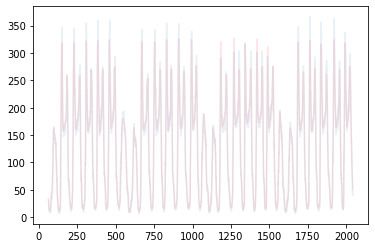

In [61]:
plt.plot(timestamps_i,np.reshape(y_test_predictions, (1978,)),alpha=0.1,color="red")
plt.plot(timestamps_i,np.reshape(y_test, (1978,)),alpha=0.1)

In [49]:
def ma(ts,window):
    ts_points = []
    for i in range(window,len(ts)):
        ts_points.append(np.sum(ts[(i-window):i])/window)
    return ts_points

def norm(vec):
    return np.sqrt(np.sum([x**2 for x in vec]))

def cosine_sim(vec1,vec2):
    return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))

def deltas(vec):
    diffs = []
    for i in range(1,len(vec)):
        diffs.append(vec[i]-vec[i-1])
    return diffs
# cosine similarity between pairwise difference vectors (x_i-x_{i-1})
def most_similar_segments(start_idx,end_idx,ts,k,compute_diff=False,avg_diff=False):
    cmp_window = ts[start_idx:end_idx]
    if compute_diff:
        cmp_window = deltas(cmp_window)
    window_size = end_idx-start_idx
    L = []
    heapq.heapify(L)
    num_segments = 0
    sim_to_region = dict()
    seen_segments = []
    for i in range(window_size,len(ts)):
        segment = ts[(i-window_size):i]
        if compute_diff:
            segment = deltas(segment)
        if avg_diff:
            sim = np.sum(np.array(cmp_window)-np.array(segment))/len(cmp_window)
        else:
            sim = correlate(cmp_window,segment)[0]
            #sim = cosine_sim(cmp_window,segment)
        sim = round(sim,6)
#         if i-window_size in set([2510,2259,2008,1757,1506,
#                                 1255,1004,753,502,0]):
#                 print(i-window_size,sim)
#         else:
#                 print("LOWER?:",i-window_size,sim)
        if len(seen_segments) != 0:
            if seen_segments[-1][-1] >= i-window_size:
                continue
        if num_segments < k:
            sim_to_region[sim] = list(range(i-window_size,i))
            heapq.heappush(L,sim)
            num_segments += 1
        else:
            least_sim_largest_dist = heapq.nsmallest(1,L)[0]
#             print("Keeping size:",len(L))
#             print("least_similar",least_sim_largest_dist)
            if sim >= least_sim_largest_dist: # number of segments exceeds k
#                 sim_to_region[sim] = list(range(i-window_size,i))
                # need to remove the least similar region if similarity is greater than 
                # the least similar one in the heap.
                sim_to_region[sim] = list(range(i-window_size,i))
                heapq.heappush(L,sim)
                del sim_to_region[least_sim_largest_dist]
                # here we pop the smallest element from L.
                heapq.heappop(L)
        seen_segments.append([i-window_size,i])
    return list(sim_to_region.values())

def most_similar_segments_2(start_idx,end_idx,ts,k,compute_diff=False,avg_diff=False):
    cmp_window = ts[start_idx:end_idx]
    if compute_diff:
        cmp_window = deltas(cmp_window)
    window_size = end_idx-start_idx
    L = []
    heapq.heapify(L)
    num_segments = 0
    sim_to_region = dict()
    seen_segments = []
    for size in range(window_size,int(1.25*window_size)):
        for i in range(size+1,len(ts)):
            segment = ts[(i-(size+1)):i]
            if compute_diff:
                segment = deltas(segment)
            if avg_diff:
                assert len(segment) == len(cmp_window), "cmp_window and length of segment not equivalent."
                sim = np.sum(np.array(cmp_window)-np.array(segment))/len(cmp_window)
            else:
                sim = correlate(cmp_window,segment)[0]
            sim = round(sim,6)
            if len(seen_segments) != 0:
                if seen_segments[-1][-1] >= i-size:
                    continue
            if num_segments < k:
                sim_to_region[sim] = list(range(i-size,i))
                heapq.heappush(L,sim)
                num_segments += 1
            else:
                least_sim_largest_dist = heapq.nsmallest(1,L)[0]
                if sim >= least_sim_largest_dist: # number of segments exceeds k
                    # need to remove the least similar region if similarity is greater than 
                    # the least similar one in the heap.
                    sim_to_region[sim] = list(range(i-size,i))
                    heapq.heappush(L,sim)
                    del sim_to_region[least_sim_largest_dist]
                    # here we pop the smallest element from L.
                    heapq.heappop(L)
            seen_segments.append([i-size,i])
    return list(sim_to_region.values())

In [54]:
pems08_data["test_x"][:,3,0,0]

array([0.50226424, 1.12029984, 1.41558351, ..., 0.03530402, 0.12457582,
       0.10397464])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


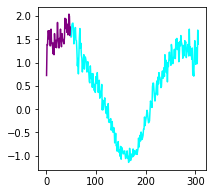

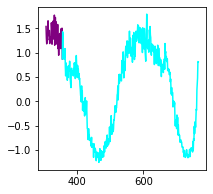

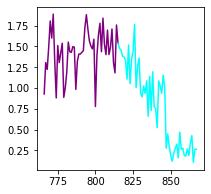

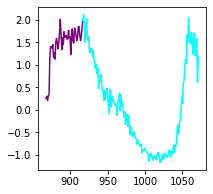

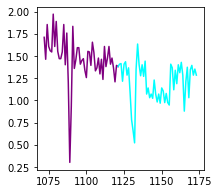

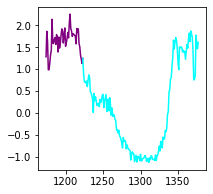

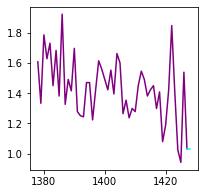

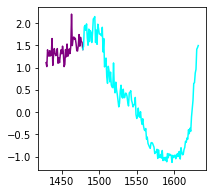

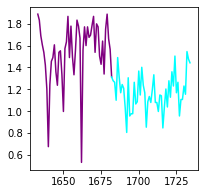

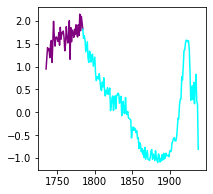

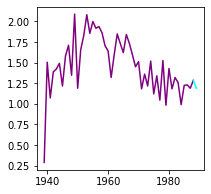

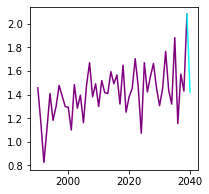

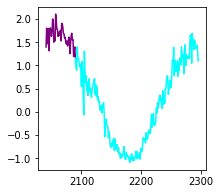

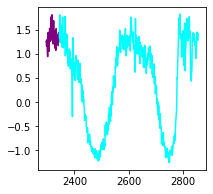

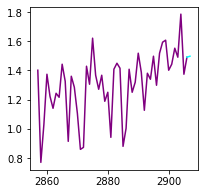

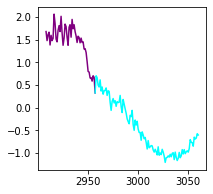

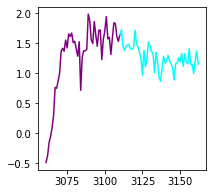

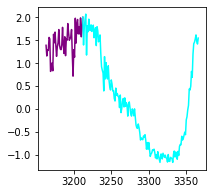

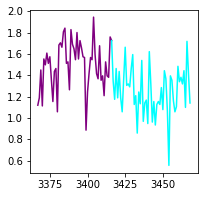

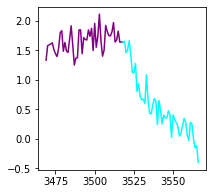

<Figure size 216x216 with 0 Axes>

In [50]:
plot_similar_cyclic_regions(most_similar_segments_2(0,50, list(pems08_data["test_x"][:,0,0,0]),20),
                            pems08_data["test_x"][:,0,0,0])

In [26]:
'''
:brief: finds the previous interval that's not overlapping with 
the jth one.
:param: intervals
:param: j
:return: position of the non-overlapping 
interval in the list of intervals, used to index into OPT.
'''
def are_overlapping(interval_1,interval_2):
    return interval_2[0] <= interval_1[1] and interval_2[1] >= interval_1[0]
def get_prec(intervals, j):
    prec = None
    curr_idx = j-1
    while curr_idx >= 0:
        curr_interval = intervals[curr_idx]
        if (not are_overlapping(curr_interval, intervals[j])):
            prec = curr_idx
            break
        curr_idx -= 1
    return prec
'''
OPT[j] = max{OPT[prec(j)]+1,OPT[j-1]}
:brief: max_num_intervals
:param: intervals
'''
def max_num_intervals(intervals):
    intervals.sort()
    OPT = [0]*len(intervals)
    for j in range(len(intervals)):
        prec_idx = get_prec(intervals, j)
        if prec_idx is None:
            OPT[j] = (1,[intervals[j]])
        else:
            OPT[j] = ((OPT[prec_idx][0]+1), OPT[prec_idx][1]+[intervals[j]]) \
                     if (OPT[prec_idx][0]+1) > OPT[j-1][0]\
                     else OPT[j-1]
    return OPT[-1]
    

In [27]:

'''
:brief: modify_seqs is a helper function called in get_consecutive_diffs
that finds the cumulative number of observations that are consecutively 
'''
def modify_seqs(prev, diffs, i, curr_seq, cons_seq, is_positive=True):
    if prev is None:
        prev = diffs[i]
    
    if ((is_positive and prev > 0 and diffs[i] > 0) or\
        ((not is_positive) and prev < 0 and diffs[i] < 0)):
        curr_seq += 1
        if (curr_seq > 1):
            cons_seq += 1
            prev = diffs[i]
    else:
        curr_seq = 0
        prev = None
    return prev, curr_seq, cons_seq

'''
:param: threshold 
:param: diffs
'''
def get_consecutive_diffs(threshold, diffs,look_at_positive_diffs=True):
    cons_seq_pos, curr_seq_pos = 0, 0
    cons_seq_neg, curr_seq_neg = 0, 0
    prev_pos, prev_neg = None, None
    for i in range(len(diffs)):
        if (look_at_positive_diffs):
            prev_pos, curr_seq_pos, cons_seq_pos = modify_seqs(prev_pos, 
                                                  diffs, 
                                                  i, 
                                                  curr_seq_pos,
                                                  cons_seq_pos)
        else:
            prev_neg, curr_seq_neg, cons_seq_neg = modify_seqs(prev_neg, 
                                                  diffs, 
                                                  i,
                                                  curr_seq_neg,
                                                  cons_seq_neg,
                                                  is_positive=False)
    # we add 1 to account for initial consecutive sequence of 2 
    # elements where we exclude the first element.
    if (look_at_positive_diffs):
        return ((cons_seq_pos+1)/len(diffs)) >= threshold
    return ((cons_seq_neg+1)/len(diffs)) >= threshold

# basic algorithm from thesis writeup.
def find_optim_changes(vec, length, k):
    optim_changes = []
    heapq.heapify(optim_changes)
    for i in range(length, len(vec)):
        diffs = deltas(np.array(vec[(i-length):i]))
        smoothed_points = linear_smoother(diffs, 15)[1]
        if get_consecutive_diffs(0.6, smoothed_points):
            euclidean_norm = np.sqrt(np.sum(np.square(np.array(diffs))))
            if len(optim_changes) < k:
                heapq.heappush(optim_changes, [i-length, i, euclidean_norm])
            else:
                smallest_change = heapq.nsmallest(1,optim_changes)[0][2]
                if (euclidean_norm > smallest_change):
                    low_val = heapq.heappop(optim_changes)
                    heapq.heappush(optim_changes,[i-length, i, euclidean_norm])
    optim_intervals = list(map(lambda l: l[:2], optim_changes))
    optim_intervals = max_num_intervals(optim_intervals)
    return optim_intervals
    
def optim_change(vec,length,greatest=True):
    change_start = 0 
    if (greatest):
        change = 0
    else:
        change = float('inf')
    for i in range(length, len(vec)):
        diffs = deltas(np.array(vec[(i-length):i]))
        smoothed_points = linear_smoother(diffs, 15)[1]
        euclidean_norm = np.sqrt(np.sum(np.square(np.array(diffs))))
        if (get_consecutive_diffs(0.7, smoothed_points)):
            if (greatest):
                if (euclidean_norm > change):
                    change = euclidean_norm
                    change_start = i-length
            else:
                if (euclidean_norm < change):
                    change = euclidean_norm
                    change_start = i-length
    
    return change_start

In [27]:
# L = [[1857, 1957, 3.047289297412684],
#  [1864, 1964, 3.0827449727668896],
#  [1859, 1959, 3.0507459803599937],
#  [2019, 2119, 2.9483137773373578],
#  [1873, 1973, 3.234881948241255],
#  [1862, 1962, 3.068216895662814],
#  [1866, 1966, 3.1086561606513556],
#  [3155, 3255, 3.1609154976631246],
#  [3159, 3259, 3.0850233737889323],
#  [3160, 3260, 3.083914966101095],
#  [2308, 2408, 3.048913730507758],
#  [1863, 1963, 3.070675009256628],
#  [2298, 2398, 3.1045729022233144],
#  [2301, 2401, 3.101715983965881],
#  [3161, 3261, 3.079752970442627]]
# L = list(map(lambda l: l[:2], L))
# max_num_intervals(L)

In [55]:
pems08_crests = [[0,50],[235,385],[530,645],[760, 810],
                 [880,920],[1050,1200],[1340,1490],
                 [1630,1770],[1910,2060],[2240,2400],
                 [2540,2640],[2780,2920],[3080,3230],[3355,3500]]
pems08_downward = [[50,125],[385,425],[645,685],[810,840],
                  [920,980],[1200,1250],[1490,1540],
                  [1770,1840],[2060,2130],[2400,2440],
                  [2640,2710],[2920,2990],[3230,3280],[3500,3567]]
pems08_troughs = [[125,185],[425,500],[685,745],[840,860],
                  [980,1030],[1250,1320],[1540,1610],
                  [1840,1890],[2130,2180],[2440,2490],
                 [2710,2760],[2990,3050],[3280,3340]]
pems08_upward = [[185, 235],[500,530],[745,760],[860,880],
                [1030,1050],[1320,1340],[1610,1630],
                [1890,1910],[2180,2240],[2490,2540],
                [2760,2780],[3050,3080],[3340,3355]]
pems08_portions = {"crests":pems08_crests,
                  "downward": pems08_downward,
                  "trouths":pems08_troughs,
                  "upward":pems08_upward}
np.save("pems08_portions.npy", pems08_portions)

In [123]:
pems04_crests = [[50,175],[360,460],[620,770],[890,1020],[1170,1310],[1480,1600],[1760,1880],[2060,2160],
                [2360,2460],[2640,2740],[2900,3050],[3190,3340]]
pems04_downward = [[175,230],[460,520],[770,800],[1020,1090],[1310,1380],[1600,1670],[1880,1970],[2160,2260],
                  [2460,2540],[2740,2820],[3050,3100],[3340,3394]]
pems04_troughs = [[230,320],[520,570],[800,860],[1090,1150],[1380,1440],[1670,1730],[1970,2020],[2260,2320],
                 [2540,2590],[2820,2880],[3100,3160]]
pems04_upward = [[0,50],[320,360],[570,620],[860,890],[1150,1170],[1440,1480],[1730,1760],[2020,2060],
                 [2320,2360],[2590,2640],[2880,2900],[3160,3190]]
pems04_portions = {"crests":pems04_crests,
                  "downward": pems04_downward,
                  "trouths":pems04_troughs,
                  "upward":pems04_upward}
np.save("pems04_portions.npy", pems04_portions)

In [124]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


In [129]:
crests_4 = list(map(lambda x: x+["red"], pems04_crests))
downward_4 = list(map(lambda x: x+["blue"], pems04_downward))
troughs_4 = list(map(lambda x: x+["green"], pems04_troughs))
upward_4 = list(map(lambda x: x+["purple"], pems04_upward))

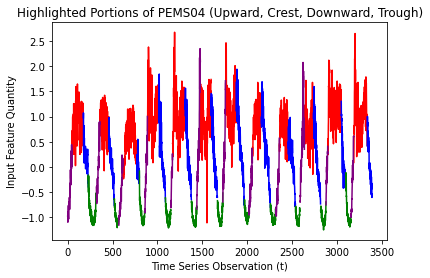

In [136]:
for start,end,col in crests_4+downward_4+troughs_4+upward_4:
    plt.plot(range(start,end),pems04_data["test_x"][start:end,0,0,11],color=col)
plt.title("Highlighted Portions of PEMS04 (Upward, Crest, Downward, Trough)")
plt.ylabel("Input Feature Quantity")
plt.xlabel("Time Series Observation (t)")
plt.savefig("pems04_regions.png")

In [139]:
crests_8 = list(map(lambda x: x+["red"], pems08_crests))
downward_8 = list(map(lambda x: x+["blue"], pems08_downward))
troughs_8 = list(map(lambda x: x+["green"], pems08_troughs))
upward_8 = list(map(lambda x: x+["purple"], pems08_upward))

In [31]:
for start,end,col in crests_8+downward_8+troughs_8+upward_8:
    plt.plot(range(start,end),pems08_data["test_x"][start:end,0,0,11],color=col)
plt.title("Highlighted Portions of PEMS08 (Upward, Crest, Downward, Trough)")
plt.ylabel("Input Feature Quantity")
plt.xlabel("Time Series Observation (t)")
plt.savefig("pems08_regions.png")

NameError: name 'crests_8' is not defined

In [28]:
#Reading in traffic flow from a specific day.
#a414_train[a414_train["Date"].str.match("1/2/13")]["Flow"]

In [29]:
split_date = pd.to_datetime("2/1/14 0:00")
a414_train = A414df[pd.to_datetime(A414df["Date"]) < split_date]
a414_test = A414df[pd.to_datetime(A414df["Date"]) >= split_date]

In [67]:
# pems08_data["test_x"][:,0,0,i] at position p is the p+i forecasted observation
# of the data.
'''
RECALL that the random substitution of portions of the time series 
with future data is only on the INPUT. This lessens the amount of 
data in the input.
We may need to cut off the prediction up to the future substitution portion (portion 2).
[portion 1]....[portion 2]
'''
pems08_data["test_x"][:,0,0,11]

array([ 1.42931763,  1.42931763,  1.36064701, ..., -0.47972564,
       -0.43852327, -0.47972564])

In [165]:

a414_crests = [[40,70],[140,170],[220,260],[315,355],[410,450],[505,550],[605,645],
               [710,740],[810,840],[890,930],[990,1030],[1080,1120],[1180,1220],
               [1275,1315],[1385,1400],[1480,1510],[1565,1600],[1660,1700],
               [1755,1800],[1850,1890],[1945,1990],[2060,2080],[2150,2185],
               [2235,2275],[2330,2375],[2430,2470],[2525,2565],
               [2620,2660]]

a414_downward = [[70,90],[170,190],[260,280],[355,380],[450,470],[550,570],[645,665],
                 [740,760],[840,860],[930,950],[1030,1050],[1120,1140],[1220,1240],
                 [1315,1335],[1400,1440],[1510,1530],[1600,1620],[1700,1720],
                 [1800,1820],[1890,1910],[1990,2020],[2080,2110],
                 [2185,2210],[2275,2300],[2375,2400],[2470,2500],[2565,2590],
                 [2660,2688]]

a414_troughs = [[0,20],[90,120],[190,210],[280,305],[380,400],[470,500],[570,590],
                [665,690],[760,790],[860,880],[950,980],[1050,1070],[1140,1170],
                [1240,1265],[1335,1365],[1440,1460],[1530,1550],[1620,1650],
                [1720,1745],[1820,1840],[1910,1940],[2020,2035],
                [2210,2225],[2300,2320],[2400,2420],[2500,2515],[2590,2610]]

a414_upward = [[20,40],[120,140],[210,220],[305,315],[400,410],[500,505],[590,605],
               [690,710],[790,810],[880,890],[980,990],[1070,1080],[1170,1180],
               [1265,1275],[1365,1385],[1460,1480],[1550,1565],[1650,1660],
               [1745,1755],[1840,1850],[1940,1945],[2035,2060],[2140,2150],
               [2225,2235],[2320,2330],[2420, 2430],[2515,2525],
               [2610,2620]]

a414_portions = {"crests":a414_crests,
                  "downward": a414_downward,
                  "trouths": a414_troughs,
                  "upward": a414_upward}
np.save("a414_portions.npy", a414_portions)

In [209]:
import datetime
start_date = datetime.datetime.strptime("01/01/13", "%m/%d/%y")
datetime.datetime.strftime(datetime.datetime.strptime("01/01/13", "%m/%d/%y")+datetime.timedelta(days=43),
                           "%m/%d/%y")
(datetime.datetime.strptime("01/01/13", "%m/%d/%y")+datetime.timedelta(days=0)).weekday()

1

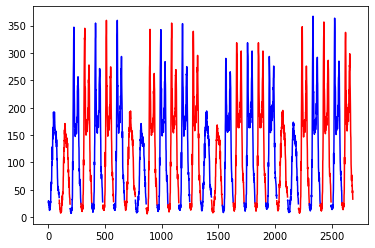

In [214]:
chunk_idx = 0
for i in range(0,len(a414_test),96):
    if (chunk_idx%2==0):
        col = "blue"
    else:
        col = "red"
    plt.plot(range(i,i+96),a414_test[i:i+96]["Flow"],
            color=col)
    chunk_idx += 1
plt.savefig("separated_days.png")

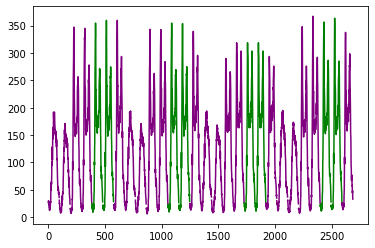

In [213]:
chunk_idx = 0
for i in range(0,len(a414_test),96):
    weekday_num = (datetime.datetime.strptime("01/01/13", "%m/%d/%y")+\
                   datetime.timedelta(days=chunk_idx)).weekday()
    if (weekday_num in {5,6}):
        col = "green"
    else:
        col = "purple"
    plt.plot(range(i,i+96),a414_test[i:i+96]["Flow"],
            color=col)
    chunk_idx += 1
plt.savefig("weekday_weekend.png")

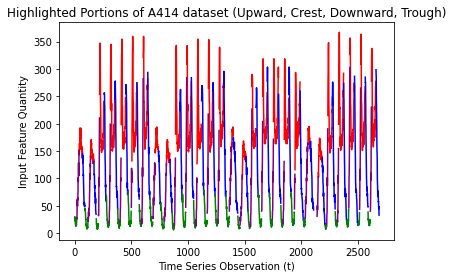

In [169]:
#print(a414_test[a414_test["Date"].str.match("1/8/13")]["Flow"])
crests_a414 = list(map(lambda x: x+["red"], a414_crests))
downward_a414 = list(map(lambda x: x+["blue"], a414_downward))
troughs_a414 = list(map(lambda x: x+["green"], a414_troughs))
upward_a414 = list(map(lambda x: x+["purple"], a414_upward))
for start,end,col in crests_a414+downward_a414+troughs_a414+upward_a414:
    plt.plot(range(start,end),a414_test["Flow"][start:end],color=col)
plt.title("Highlighted Portions of A414 dataset (Upward, Crest, Downward, Trough)")
plt.ylabel("Input Feature Quantity")
plt.xlabel("Time Series Observation (t)")
plt.savefig("a414_regions.png")

In [155]:
find_optim_changes(pems08_data["test_x"][:,0,0,11], 150, 30)

(4, [[178, 328], [425, 575], [1567, 1717], [2165, 2315]])

In [107]:
optim_change(pems08_data["test_x"][:,0,0,11], 100, True)

3162

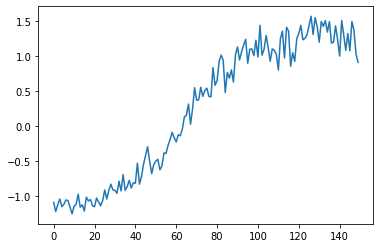

In [154]:
pplot(pems08_data["test_x"][446:(446+150),0,0,11])

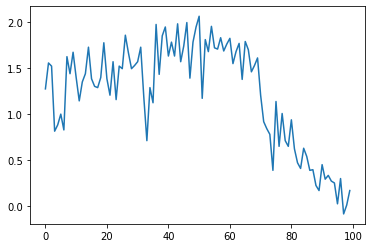

In [136]:
pplot(pems08_data["test_x"][3155:(3155+100),0,0,11])
#[[1873, 1973], [2019, 2119], [2298, 2398], [3155, 3255]]

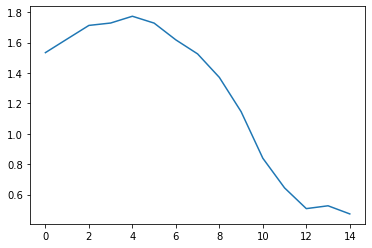

In [139]:
smoothed_points = linear_smoother(pems08_data["test_x"][2019:(2019+100),0,0,11], 15)[1]
plt.plot(range(len(smoothed_points)), smoothed_points)

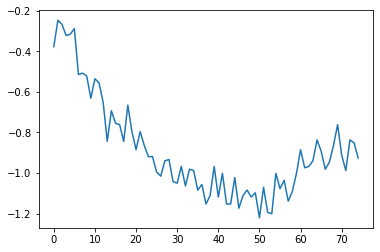

In [18]:
pplot(pems08_data["test_x"][2427:(2427+75),0,0,11])

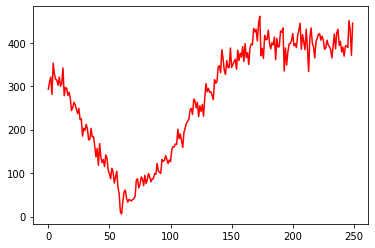

In [36]:
# list(pems8_data[:,0,2])[250:375]
plt.plot(list(range(250)),pems8_data[250:500,0,0],color="red")

In [37]:
sim_segs = most_similar_segments(250,500, list(pems8_data[:,0,0]),20)

dict_keys([24833126.0, 24728671.0, 24658817.0, 25513740.0, 25097752.0, 30301478.0, 31613115.0, 33581108.0, 28525394.0, 26026070.0, 25983233.0, 26068427.0, 25167642.0, 26235244.0, 25938552.0, 25509364.0, 24608878.0, 25976356.0, 25519059.0, 24623103.0])


In [42]:
# PEMS08 average speeds
def plot_similar_cyclic_regions(indices, ts):
    indices = sorted(indices, key=lambda x: x[0])
    lsts_idx_excluded = []
    curr_end = None
    #plt.plot(list(range(250)),pems8_data[250:500,0,0],color="yellow")
    plt.figure(figsize=(3, 3))
    # we assume non-overlapping indices
    for i,index_lst in enumerate(indices):
        plt.plot(index_lst,ts[index_lst],color="purple")
        if i == len(indices)-1:
            indices_to_end = list(range(index_lst[-1],len(ts)))
            plt.plot(indices_to_end,
                     ts[indices_to_end],
                    color="cyan")
        else:
            indices_in_between = list(range(index_lst[-1],indices[i+1][0]))
            plt.plot(indices_in_between,
                     ts[indices_in_between],
                    color="cyan")
        if i == 0 and index_lst[0] > 0:
            plt.plot(list(range(0,index_lst[0])),ts[:index_lst[0]],color="green")
        plt.figure(figsize=(3, 3))
    plt.show()
# cyan is data in the time series that aren't part of the most similar regions.
# 

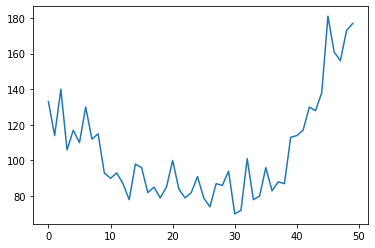

In [30]:
pplot(pems8_data[0:50,0,0])

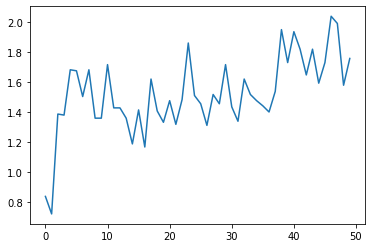

In [40]:
pplot(pems08_data["test_x"][0:50,0,0,0])

In [14]:
sim_segs_all = [[idx for idx in seg] for seg in sim_segs]
sim_segs_idx = [idx for seg in sim_segs for idx in seg]
print(len(set(pems8_data[sim_segs_idx,0,0])))
print(len(pems8_data[sim_segs_idx,0,0]))

496
5000


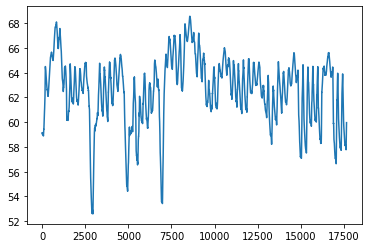

In [61]:
pems8_ma = ma(pems8_data[:,0,2],200)
plt.plot(list(range(len(pems8_ma))),pems8_ma)

In [ ]:
incomplete_highways_england_data = pd.read_csv("../")

In [52]:
predictions_ASTGCN = np.load('output_epoch_65_test.npz')

In [53]:
# Keys within the predictions output
for key in predictions_ASTGCN.keys():
    print(key)

input
prediction
data_target_tensor


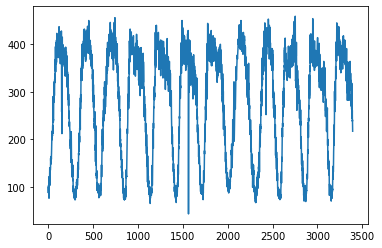

In [63]:
detector = 5
plt.plot(predictions_ASTGCN["input"][:,detector,0,1])

In [56]:
# prediction window is over 1 hour in the future .

In [92]:
predictions_ASTGCN["input"][:,detector,0,11]

array([ 53.99999668,  53.99999668,  34.99999075, ..., 132.99999801,
       111.99999612, 122.99999955])

In [80]:
predictions_ASTGCN["input"][:,detector,0,7]

array([ 52.99999637,  49.99999543,  43.99999356, ..., 145.00000175,
       156.00000052, 137.99999957])

In [69]:
predictions_ASTGCN["data_target_tensor"][:,detector,0]

array([ 54.,  35.,  48., ..., 112., 123., 118.], dtype=float32)

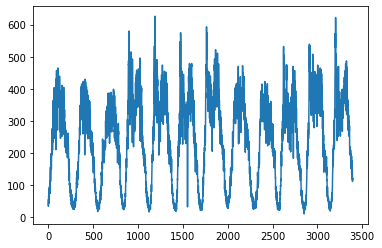

In [68]:
plt.plot(predictions_ASTGCN["data_target_tensor"][:,detector,0])

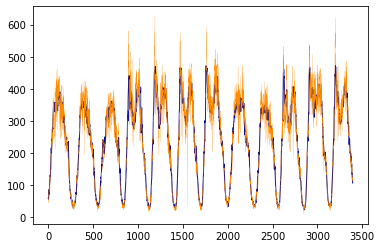

In [56]:
detector = 0
predicted_ts = predictions_ASTGCN["prediction"][:,detector,2]
plt.plot(list(range(len(predicted_ts))),predicted_ts,
         linewidth=1, color="darkblue",label="predicted")
true_ts = predictions_ASTGCN["data_target_tensor"][:,detector,2]
plt.plot(list(range(len(true_ts))),true_ts,
         linewidth=0.2,color="darkorange")



In [97]:
# 12 - forecasted target is the traffic flow.
print(predictions_ASTGCN["prediction"][:,detector,2])
predictions_ASTGCN["input"][:,detector,0,2]

[ 60.279232  61.571598  56.867813 ... 120.79352  111.26196  107.287994]


array([ 49.99999543,  56.99999762,  39.99999231, ..., 190.99999978,
       149.99999865, 120.99999893])

In [33]:
def pairwise_diff(vec1,vec2):
    assert type(vec1) == type(vec2) and type(vec1) == np.ndarray
    return vec1-vec2

In [37]:
diffs = pairwise_diff(np.array(true_ts),np.array(predicted_ts))

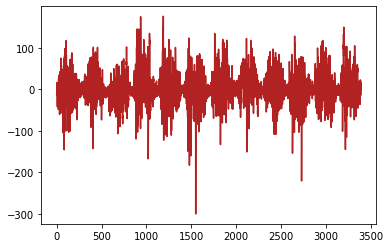

In [39]:
plt.plot(list(range(len(diffs))),diffs,color="firebrick")